In [1]:
!pip install torch
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)

In [3]:
import torch
import transformers
import random

# vrc SEED = 100
SEED = 100 #vrc
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
!pip install datasets

In [5]:

from datasets import load_dataset
dataset = load_dataset(
   'imdb')

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
train = dataset["train"]
test = dataset["test"]

In [7]:
import pandas as pd

print(pd.DataFrame(train))

                                                    text  label
0      I rented I AM CURIOUS-YELLOW from my video sto...      0
1      "I Am Curious: Yellow" is a risible and preten...      0
2      If only to avoid making this type of film in t...      0
3      This film was probably inspired by Godard's Ma...      0
4      Oh, brother...after hearing about this ridicul...      0
...                                                  ...    ...
24995  A hit at the time but now better categorised a...      1
24996  I love this movie like no other. Another time ...      1
24997  This film and it's sequel Barry Mckenzie holds...      1
24998  'The Adventures Of Barry McKenzie' started lif...      1
24999  The story centers around Barry McKenzie who mu...      1

[25000 rows x 2 columns]


In [8]:
import pandas as pd

df_train = pd.DataFrame(list(zip(train['text'], train['label'])), 
                        columns =['text', 'label'])
df_test = pd.DataFrame(list(zip(test['text'], test['label'])), 
                        columns =['text', 'label'])

In [9]:
df_train.label.value_counts()

1    12500
0    12500
Name: label, dtype: int64

In [10]:
dataset = df_train.sample(n = 25000, random_state = SEED).reset_index(drop=True)

In [11]:
dataset.label.value_counts()

1    12500
0    12500
Name: label, dtype: int64

In [12]:
#Checking Null values
dataset.isnull().sum()

text     0
label    0
dtype: int64

In [13]:
#Replacing the target class '4' with '1'
dataset['label'].replace({4: 1}, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


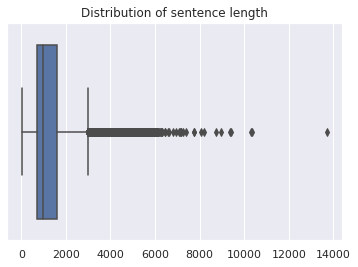

In [14]:
# See the distribution of sentence length 
sen_length = [len(x) for x in dataset.text.tolist()]
sns.boxplot(sen_length)
plt.title('Distribution of sentence length')
plt.show()

**Splitting Dataset into train, Validtion and test**

In [15]:
from sklearn.model_selection import train_test_split

X = dataset.text.values
y = dataset.label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.38, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=SEED)

**BERT Tokenizer**

In [16]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Text Pre-Processing and BERT Tokenizing**

In [17]:
import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    text = text.lower()
    
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [18]:
print('Original: ', X_train[0])
print('Processed: ', text_preprocessing(X_train[0]))

Original:  I am a dumber person for renting the DVD REDLINE. Chicago Pictures who made this stupid movie never paid Palisades Media Group to buy web ads on various automotive sites including mine which has an ALEXA rating of 16K. They ripped me off on the deal and now I am out $16,000 and they wasted much of my personal time (peter rapport of Palisades Media) you know who you are!<br /><br />Please don't rent or buy this movie!!! It sucks and the people behind it are ripoff artists.<br /><br />REDLINE has a cast of losers and poor actors!<br /><br />This movie is a Joke
Processed:  i am a dumber person for renting the dvd redline. chicago pictures who made this stupid movie never paid palisades media group to buy web ads on various automotive sites including mine which has an alexa rating of 16k. they ripped me off on the deal and now i am out $16,000 and they wasted much of my personal time (peter rapport of palisades media) you know who you are!<br /><br />please don't rent or buy th

In [19]:
token_lens = []

for txt in dataset.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


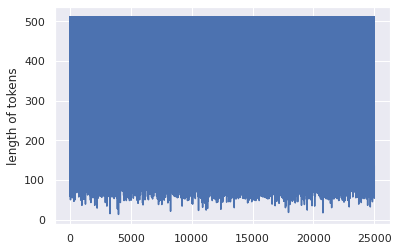

Maximum length is:  512


In [20]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(token_lens)+1), token_lens)
plt.ylabel('length of tokens')
plt.show()

MAX_LEN = max(token_lens)
print("Maximum length is: ", MAX_LEN)
# when sample with first 40k and last 40k we got the maximum length is 230. And if we sampled with inbuilt function we got 126

In [21]:
# Specify `MAX_LEN`
# MAX_LEN = 165


In [22]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [23]:
# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  I actually like this movie even though I don't fancy James Belushi very much. In this movie, you can actually see several big names on the rise, Linda Hamilton and Courteney Cox namely; Caine's was already big of course. The plot in this movie is simple; its just like that Sliding Door movie. It however was told in a light-hearted manner and I like the comedy moments in it. It made me trying to relive my own important moments in live, eg what if I've taken that girl out for a movie, and not the other etc. It tells us that people around us could have taken different roles in our lives if some minute details were to change. It also reminds us to be careful what we wish for. Life is not always as good on the other side as we think; maybe, what we have now is the best for us, all things considered.
Token IDs:  [101, 1045, 2941, 2066, 2023, 3185, 2130, 2295, 1045, 2123, 1005, 1056, 11281, 2508, 19337, 20668, 2072, 2200, 2172, 1012, 1999, 2023, 3185, 1010, 2017, 2064, 2941, 2156, 

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [24]:
# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Tokenizing data...


In [25]:
#convert lists to tensors
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

In [26]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle = True, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, shuffle = True, batch_size = batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

**BERT Classification**

In [27]:
from transformers import BertForSequenceClassification,AdamW

In [28]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, output_attentions = False, output_hidden_states = False)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [29]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [31]:
# optimizer = AdamW(model.parameters(),lr = 2e-5,decayeps=1e-8)
optimizer = AdamW(
    model.parameters(),
    lr=5e-5, # Initializing the learning Rate as suggested in the T5 official documentation
    eps=(1e-8),
)

In [32]:
from transformers import get_linear_schedule_with_warmup
epochs = 2
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [33]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [34]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [ ]:
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(val_dataloader)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')
    

In [ ]:
torch.save(model.state_dict(),'saving_imdb_model.bin')

In [ ]:
test_loss, test_predictions, test_vals = evaluate(test_dataloader)
test_acc = accuracy(test_predictions, test_vals)

In [ ]:
test_acc

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
test_preds = np.argmax(test_predictions,axis=1)
test_labels = test_vals
cm=confusion_matrix(test_labels, test_preds)
cm


In [ ]:
print(classification_report(test_labels, test_preds.round()))

In [ ]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

## Use IMDB pre-trained model on Twitter dataset

In [42]:
from datasets import load_dataset

dataset1 = load_dataset('sentiment140')

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/739 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.4M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sentiment140 downloaded and prepared to /root/.cache/huggingface/datasets/sentiment140/sentiment140/1.0.0/f81c014152931b776735658d8ae493b181927de002e706c4d5244ecb26376997. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [43]:
train = dataset1["train"]
test = dataset1["test"]

In [44]:
df_train = pd.DataFrame(list(zip(train['text'], train['sentiment'])), 
                        columns =['text', 'sentiment'])
df_test = pd.DataFrame(list(zip(test['text'], test['sentiment'])), 
                        columns =['text', 'sentiment'])

df_train.sentiment.value_counts()

dataset = df_train.sample(n = 80000, random_state = SEED).reset_index(drop=True)

dataset.sentiment.value_counts()

#Checking Null values
dataset.isnull().sum()

#Replacing the target class '4' with '1'
dataset['sentiment'].replace({4: 1}, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


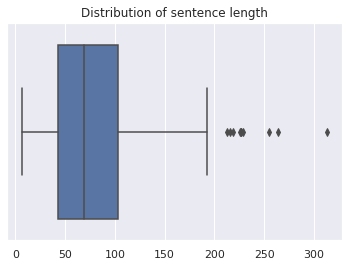

In [45]:
# See the distribution of sentence length 
sen_length = [len(x) for x in dataset.text.tolist()]
sns.boxplot(sen_length)
plt.title('Distribution of sentence length')
plt.show()

**Splitting Dataset into train, Validtion and test**


In [47]:
from sklearn.model_selection import train_test_split

X = dataset.text.values
y = dataset.sentiment.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.38, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=SEED)

In [48]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
import re
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    text = text.lower()
    
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

print('Original: ', X_train[0])
print('Processed: ', text_preprocessing(X_train[0]))


Original:  Read &quot;The Giver&quot; last night. Not really getting the ending. Found the plot innocently disturbing. May have to re-read. 
Processed:  read &quot;the giver&quot; last night. not really getting the ending. found the plot innocently disturbing. may have to re-read.


In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [50]:
token_lens = []

for txt in dataset.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


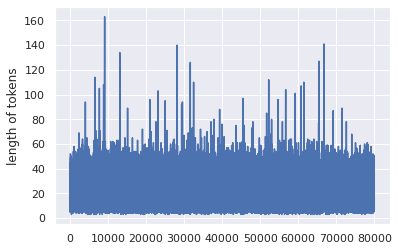

Maximum length is:  163


In [51]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(token_lens)+1), token_lens)
plt.ylabel('length of tokens')
plt.show()

MAX_LEN = max(token_lens)
print("Maximum length is: ", MAX_LEN)
# when sample with first 40k and last 40k we got the maximum length is 230. And if we sampled with inbuilt function we got 126

In [52]:
MAX_LEN=64

In [53]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks


In [54]:

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)

#convert lists to tensors
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  @nicholasmw 1 day u will find that girl worry 
Token IDs:  [101, 1030, 6141, 2213, 2860, 1015, 2154, 1057, 2097, 2424, 2008, 2611, 4737, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [55]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle = True, batch_size = batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, shuffle = True, batch_size = batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_dataloader = DataLoader(test_data, shuffle = True, batch_size = batch_size)

In [56]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

from transformers import get_linear_schedule_with_warmup
epochs = 2
total_steps = len(train_dataloader)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [57]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals


In [58]:

from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(val_dataloader)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1085 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.41085018920733635
Validation loss: 0.37243736184412435
Accuracy: 0.8379704301075269


Epoch 2:   0%|          | 0/1085 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.2852797082766959
Validation loss: 0.3865489626603742
Accuracy: 0.8404569892473118


In [59]:
test_loss, test_predictions, test_vals = evaluate(test_dataloader)
test_acc = accuracy(test_predictions, test_vals)

In [60]:
test_acc

0.8350986842105264

In [61]:
from sklearn.metrics import confusion_matrix, classification_report
test_preds = np.argmax(test_predictions,axis=1)
test_labels = test_vals
cm=confusion_matrix(test_labels, test_preds)
cm


array([[12811,  2405],
       [ 2608, 12576]])

In [62]:
print(classification_report(test_labels, test_preds.round()))

              precision    recall  f1-score   support

           0       0.83      0.84      0.84     15216
           1       0.84      0.83      0.83     15184

    accuracy                           0.84     30400
   macro avg       0.84      0.84      0.84     30400
weighted avg       0.84      0.84      0.84     30400



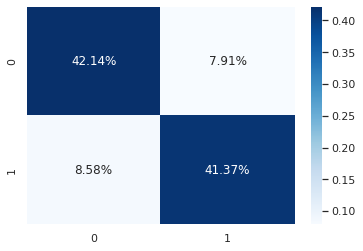

In [63]:
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')